# DOP Project

=====

The primary aim of this exercise is to set up a **cross hedging** scenario by using **monthly price changes**. Recall that a **cross hedge** is essentially a type of hedging strategy wherein the asset that exposes an investor to price volatility in the cash market, is offset by having a position in the futures market such that the underlying asset is different from the asset causing us exposure. The methodology in this analysis consists of the following key concepts:

1. **Hedge Ratio**: In a cross hedging scenario, correlations between the underlying asset and asset causing price risk, are usually quite different. The main attempt is to have a **minimum variance hedge ratio** and is given by the expression below. Note in addition that this obtained by the **slope** of the best fit line by regressing **change in spot price** on **change in futures price**.

$$h^* = \dfrac{\rho\sigma_S}{\sigma^F}$$


2. **Hedge effectiveness**: This is the proportion of variance that is eliminated by hedging. It is essentially the **goodness of fit** or $R^2$ measure from our regression results and is also denoted by $\rho^2$.

3. **Data preparation**: Data is prepared by **backadjusting** using the **nearest month approach** so as to obtain a continuous series of futures prices. 

4. **Testing the model**: Finally the model is tested on a **holdout sample** so as to judge the hedge effectiveness on the new data.

&nbsp;

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
plt.style.use('seaborn-whitegrid')

&nbsp; 

## The data: Preparation and Adjustments

Futures data for the last $2$ years has been taken. The **stock future** is chosen to be that of **Reliance Industries**. Below there is a quick glance at the raw data after separating out only the relevant columns of - **date, expiry date, close price**.

&nbsp;

In [308]:
df2.iloc[: ,3:].head(4)

,date,exp_date,close
0,2020-09-11,2020-09-24,2320.10
1,2020-09-11,2020-11-26,2334.00
2,2020-09-11,2020-10-29,2329.65
3,2020-09-10,2020-11-26,2331.75


&nbsp;

Now before starting out with **backadjusting** the data, the matching points of **expiry date** and **date** are found. These are important to our backadjusting process. The idea is essentially this:

- Suppose there is a **23 April 2020** future contract and the date today is also **23 April 2020**. Also suppose that on the same date there is another contract of **5 June 2020** existing on the same date. Now it is obvious that both these contracts would have had different historical price values. This is the reason that **gaps** are usually noticed in futures data. Now to correct this and make it continuous, we take the difference of the **date of expiry** contract of **23 April 2020** and find the difference in its price that day, with that of the **nearest month** future contract, which in this case is **5 June 2020**. Suppose the difference in price is $+7.25$. Then we would essentially add this amount to **all** the futures contract values before that date. This smooths out the gaps and makes the series continuous.

&nbsp;

In [309]:
df3[df3['date']==df3['exp_date']].head(4)

,date,exp_date,close
33,2020-08-27,2020-08-27,2107.45
95,2020-07-30,2020-07-30,2111.10
167,2020-06-25,2020-06-25,1720.25
229,2020-05-28,2020-05-28,1469.05


&nbsp;

Below are the two code blocks that find these **price differences** and adjusts them to the rest of the prices, all while working **backwards**. After this, a small glimpse of the new series is presented.

&nbsp;

In [189]:
df5.iloc[1328, 2] = df5.iloc[1328, 2] + (round(df5.iloc[1329, 2] - df5.iloc[1328, 2], 2))

In [194]:
df5.iloc[1452:, 2] = df5.iloc[1452:, 2] + (round(df5.iloc[1451, 2] - df5.iloc[1452, 2], 2))

In [310]:
df5.head(5)

,date,exp_date,close
0,2020-09-11,2020-09-24,2320.10
1,2020-09-11,2020-10-29,2329.65
2,2020-09-11,2020-11-26,2334.00
3,2020-09-10,2020-11-26,2331.75
4,2020-09-10,2020-09-24,2316.30


&nbsp;

Next, we obtain **stock price** data for **HDFC**. This is considered to be the asset that we are exposed to in the cash market. 

***NOTE: HDFC and Reliance are specifically chosen because of a prior belief that there are sectoral correlations between Industrials and Financial sectors***

Further note that some of the data processing tasks involved are the following:

1. Changing the **date** fields to a **date format** so that time based adjustments could be made.

2. Changing the **price** fields to bring the price into a **numeric** format so that models could be trained without hassle. 

***Some of the code blocks are implemented these changes are presented below, just for reference.***

&nbsp;

In [218]:
hd['date'] = pd.to_datetime(hd['Date '])

In [219]:
hd['close_stock'] = hd['close '].str.replace(',', '').astype(float)

&nbsp;

After this, we compute the **monthly price changes** in the **spot** and **futures** prices. Essentially we are computing $\Delta S$ for **HDFC** and $\Delta F$ for **Reliance futures**. Note that we calculate a ratio based change in values between successive months. After this, the combined dataset is presented. This dataset contains the following columns:

1. **close**: Is the $\Delta F$ corresponding to proportional monthly price changes for **Reliance**.

2. **close_stock**: Is the $\Delta S$ corresponding to proportional monthly price changes for **HDFC**.

***NOTE: The data views are purposely kept to a small size so as to minimize space in the document.***

&nbsp;

In [237]:
monthly = dat1.iloc[[0, 23, 45, 67, 88, 107, 127, 146, 168, 190, 210, 230, 250, 269, 292,
           313, 333, 351, 372, 391, 413, 435, 454, 474, 491], :]

In [245]:
future_chan = mon1['close'].pct_change()

In [246]:
stock_chan = mon1['close_stock'].pct_change()

In [313]:
final_data.head(4)

,close,close_stock
date,,
2020-08-11,-0.076053,0.033142
2020-07-10,-0.120892,0.032435
2020-06-10,-0.167020,-0.040668
2020-05-11,0.000860,-0.083375


&nbsp;

To get an intuitive idea about the relationships between the data, here are some **correlation** measures and a **scatterplot**. We can see that the **correlation** between the underlying asset and exposed asset is close to $44\%$.

&nbsp;

,close,close_stock
close,1.000000,0.442878
close_stock,0.442878,1.000000


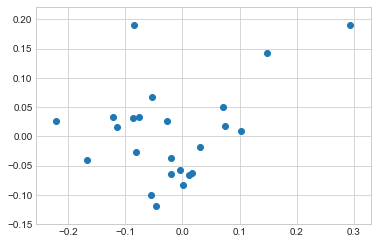

In [314]:
plt.scatter(final_data['close'], final_data['close_stock'])
final_data.iloc[5:, :].corr()

&nbsp;

## Model fit and related judgements

Here a **linear regression** model is fit on the data using the **OLS** method. Note that the regression function is basically given by:

$$\Delta S = c + h^*\Delta F$$

Where the slope of the best fit line happens to be the **optimal hedge ratio**. It can be noticed from the regression results that:

1. The **minimum variance hedge ratio** is approximately $0.4087$.

2. The coefficient is **statistically significant** with respect to a significance value of $5\%$ since the the associated **p** value is $0.04$. 

3. The **hedge effectiveness** or the **goodness of fit** is around $20\%$. This means that creating a **cross hedge** on HDFC using a Reliance future **eliminates around $20\%$ of the price risk**. 

&nbsp;

In [295]:
model = sm.OLS(final_data.iloc[5:, 1], final_data.iloc[5:, 0])

In [297]:
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:            close_stock   R-squared (uncentered):                   0.201
Model:                            OLS   Adj. R-squared (uncentered):              0.157
Method:                 Least Squares   F-statistic:                              4.528
Date:                Sun, 13 Sep 2020   Prob (F-statistic):                      0.0474
Time:                        16:25:34   Log-Likelihood:                          21.481
No. Observations:                  19   AIC:                                     -40.96
Df Residuals:                      18   BIC:                                     -40.02
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

&nbsp;

## Setting up the Hedge

First we can find the **optimal number of contracts** required as per the optimal hedge ratio. This is basically given by:

$$ N^* = h^*\dfrac{V_A}{V_F}$$

Where we have the following notations:

1. $N^*$ is the optimal number of futures contracts to buy.

2. $V_F$ is the value of one future contract.

3. $V_A$ is the value of our holding in the asset. 

&nbsp;

### Using the model

Let us assume that our portfolio consists only of $10$ shares of **HDFC**. Now let us say that we are in the month of **March** and as on **9 March 2020** our holding is worth:
$$ Rs. \ 2,027 \times 10 = Rs. \ 20,270$$

Now let us say that we want to hedge our position against any potential price fluctuations in the **HDFC** stock, so we wish to take up a **short position** in the futures market. Naturally, we would like to choose a futures contract for **HDFC** itself but we assume that it is not available and so we select the **Reliance** future contract as per our model specifications. As on **9 March 2020** the futures contract is worth $Rs. \ 1,121$. 

The optimum number of contracts is then given by:

$$N^* = 0.4087 \times \dfrac{20270}{1121} = 7.39 \approx 8$$

&nbsp;

***NOTE that we are setting up a month long hedge, so we will look at the next month position.***

Assuming that we know that futures price in the next month, that is on **9 April 2020**, we can use our model to predict **price changes** in the **spot price of HDFC**. On the basis of that we will get to know our **net hedged position**.

Before we get to computing that, here a snippet of predicted **spot price** values by our model. 

&nbsp;

In [319]:
ypredicted = results.predict(final_data.iloc[:5, 0])
ypredicted

date
2020-08-11   -0.031086
2020-07-10   -0.049413
2020-06-10   -0.068268
2020-05-11    0.000352
2020-04-09   -0.090237
dtype: float64

In [320]:
final_data.iloc[:5, 0]

date
2020-08-11   -0.076053
2020-07-10   -0.120892
2020-06-10   -0.167020
2020-05-11    0.000860
2020-04-09   -0.220769
Name: close, dtype: float64

&nbsp;

We can clearly see from the code output that the **predicted spot price change** as on **9 April 2020** is approximately:

$$\Delta S = -0.090237$$

Also from our prior knowledge we know the **change in futures price** as on **9 April 2020** to be approximately:

$$\Delta F = -0.2207$$

Now as found above, with $8$ futures contracts, our position in the futures market would be:

$$8\times (1121 - 874.6) = Rs. \ 1,971$$

Hence we are **gaining** from the **futures market** due to the **price drop**. Now we will see what is happening to our **portfolio**:

$$20270 \times (-9\%) = Rs. \ 18,445.7$$

Hence in the **spot market** we are **losing** an amount of:

$$20270 - 18445.7 = Rs. 1824.3$$

***The net position from the hedging strategy is:***

$$18445 + 1971 = Rs. \ 20416$$

***Lastly we note that the error between the actual price change in the holdout set and the predicted value of price change is only 0.07 for our particular test value. So essentially we can say that even in the actual scenario there won't be any significant difference between our predicted hedge position and the actual hedge position, should we choose to apply our strategy based on the model.***

### Checking the Hedge Effectiveness for the holdout set

Now we need to have some measure of how well this model performs in future time periods, on average. Essentially with the model characteristics we are implicitly assuming that the relationship captured by the model between **changes in futures price** and **changes in stock price**, remains the **same in the future**. We essentially extend our model to predict for future spot prices, under the assumption that the true relationship between the variables remains quite similar. It is only then that our model predictions of the future will have some semblance with actual values, thereby making our **hedge effective**. Noting that **hedge effectiveness** is actually given by either the **goodness of fit** of the regression model or the **correlation squared**. The $\rho^2$ for the test set has been calculated so as to get a sense of the true hedge effectiveness in the future.

We find that it is around $0.26$, which is infact quite close to the model $R^2$ of $0.201$. The closeness of these **hedge effectiveness** values between the training and holdout sets, suggests that our model might do a decent job at setting up effective hedges for the future, with a reasonable degree of confidence.

&nbsp;



In [26]:
(check.iloc[:5].corr())**2

,close,close_stock
close,1.000000,0.268471
close_stock,0.268471,1.000000


&nbsp;

## Conclusion

We can clearly see that by choosing this particular **cross hedge** we were successfully able to mitigate the risk arising from **HDFC** stock price volatility by **shorting** $8$ futures contracts of **Relaince**. We started off with a portfolio worth of $Rs.20,270$ and ended up with almost the same amount of $Rs.20416$. The loss due to price drop in the stock was **offset** by a corresponding gain in the futures market. Hence in this project it is clear that:

***By using continuous backadjustments in futures data, choosing decently correlated cross hedging assets, and fitting a model to find optimal hedge ratio (and hedge effectiveness), we are able to successfully predict future spot price changes and essentially have a hedging strategy that benefits us.***